In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## U-Net+ Architecture
Implementing U-Net+ (a smaller/simplified variant) with consistent configurations.

In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_rate=0.15):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate)
        )
    def forward(self, x):
        return self.conv(x)

class UNetPlus(nn.Module):
    def __init__(self, in_ch=6, out_ch=1, filters=(32,64,128,256), dropout_rates=None):
        super().__init__()
        if dropout_rates is None:
            dropout_rates = {'encoder': [0.0, 0.0, 0.1, 0.15], 'decoder':[0.15,0.15,0.15], 'final':0.0}
        f0, f1, f2, f3 = filters
        # Encoder
        self.conv0 = ConvBlock(in_ch, f0, dropout_rates['encoder'][0])
        self.conv1 = ConvBlock(f0, f1, dropout_rates['encoder'][1])
        self.conv2 = ConvBlock(f1, f2, dropout_rates['encoder'][2])
        self.conv3 = ConvBlock(f2, f3, dropout_rates['encoder'][3])
        self.pool = nn.MaxPool2d(2)
        # Decoder
        self.up3 = nn.ConvTranspose2d(f3, f2, 2, stride=2)
        self.dec2 = ConvBlock(f2+f2, f2, dropout_rates['decoder'][2])
        self.up2 = nn.ConvTranspose2d(f2, f1, 2, stride=2)
        self.dec1 = ConvBlock(f1+f1, f1, dropout_rates['decoder'][1])
        self.up1 = nn.ConvTranspose2d(f1, f0, 2, stride=2)
        self.dec0 = ConvBlock(f0+f0, f0, dropout_rates['decoder'][0])
        self.final = nn.Conv2d(f0, out_ch, 1)
    def forward(self, x):
        x0 = self.conv0(x)
        x1 = self.conv1(self.pool(x0))
        x2 = self.conv2(self.pool(x1))
        x3 = self.conv3(self.pool(x2))
        d2 = self.up3(x3)
        d2 = torch.cat([d2, x2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up2(d2)
        d1 = torch.cat([d1, x1], dim=1)
        d1 = self.dec1(d1)
        d0 = self.up1(d1)
        d0 = torch.cat([d0, x0], dim=1)
        d0 = self.dec0(d0)
        out = self.final(d0)
        return out

## Dataset and Data Loading

In [3]:
class EarthquakeDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, img_size=(256,256)):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.img_size = img_size
        if split == 'train':
            self.pre_dir = os.path.join(root_dir, 'train', 'A_train_aug')
            self.post_dir = os.path.join(root_dir, 'train', 'B_train_aug')
            self.label_dir = os.path.join(root_dir, 'train', 'label_train_aug')
        elif split == 'val':
            self.pre_dir = os.path.join(root_dir, 'val', 'A_val')
            self.post_dir = os.path.join(root_dir, 'val', 'B_val')
            self.label_dir = os.path.join(root_dir, 'val', 'label_val')
        else:
            self.pre_dir = os.path.join(root_dir, 'test', 'A_test')
            self.post_dir = os.path.join(root_dir, 'test', 'B_test')
            self.label_dir = os.path.join(root_dir, 'test', 'label_test')
        self.image_files = sorted([f for f in os.listdir(self.pre_dir) if f.endswith('.png')])
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        pre_img = Image.open(os.path.join(self.pre_dir, img_name)).convert('RGB')
        post_img = Image.open(os.path.join(self.post_dir, img_name)).convert('RGB')
        label = Image.open(os.path.join(self.label_dir, img_name)).convert('L')
        pre_img = pre_img.resize(self.img_size)
        post_img = post_img.resize(self.img_size)
        label = label.resize(self.img_size)
        if self.transform:
            pre_img = self.transform(pre_img)
            post_img = self.transform(post_img)
        else:
            pre_img = transforms.ToTensor()(pre_img)
            post_img = transforms.ToTensor()(post_img)
        label = transforms.ToTensor()(label)
        label = (label > 0.5).float()
        combined = torch.cat([pre_img, post_img], dim=0)
        return combined, label

## Loss Functions and Metrics

In [4]:
def dice_coef(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2,3))
    denom = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2. * intersection + smooth) / (denom + smooth)
    return dice.mean()
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    def forward(self, pred, target):
        dice = dice_coef(pred, target, smooth=self.smooth)
        return 1.0 - dice

def combined_loss(logits, mask, bce_weight=0.6, dice_weight=0.4):
    bce_loss = nn.BCEWithLogitsLoss()
    bce = bce_loss(logits, mask)
    probs = torch.sigmoid(logits)
    dice = DiceLoss()(probs, mask)
    return bce_weight * bce + dice_weight * dice

@torch.no_grad()
def compute_metrics_batch(logits, masks, thresh=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs >= thresh).float()
    preds_flat = preds.view(-1).cpu().numpy()
    masks_flat = masks.view(-1).cpu().numpy()
    unique_preds = np.unique(preds_flat)
    unique_masks = np.unique(masks_flat)
    if len(unique_preds) == 1 and len(unique_masks) == 1:
        if unique_preds[0] == unique_masks[0]:
            if unique_preds[0] == 1:
                tp, fp, fn, tn = len(preds_flat), 0, 0, 0
            else:
                tp, fp, fn, tn = 0, 0, 0, len(preds_flat)
        else:
            if unique_preds[0] == 1:
                tp, fp, fn, tn = 0, len(preds_flat), 0, 0
            else:
                tp, fp, fn, tn = 0, 0, len(preds_flat), 0
    else:
        cm = confusion_matrix(masks_flat, preds_flat, labels=[0,1])
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            if cm.shape == (1, 1):
                if unique_masks[0] == 0:
                    tn, fp, fn, tp = cm[0,0], 0, 0, 0
                else:
                    tn, fp, fn, tp = 0, 0, 0, cm[0,0]
            else:
                tn, fp, fn, tp = 0, 0, 0, 0
    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    dice = (2 * tp) / (2 * tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    iou_background = tn / (tn + fp + fn + eps)
    iou_damage = tp / (tp + fp + fn + eps)
    miou = (iou_background + iou_damage) / 2
    return {"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
            "iou": float(iou), "dice": float(dice), "precision": float(precision),
            "recall": float(recall), "f1": float(f1), "acc": float(acc), "miou": float(miou)}

## Training & Validation Functions

In [5]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False
    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    agg = {"tn":0,"fp":0,"fn":0,"tp":0}
    for imgs, masks in tqdm(loader, desc="Train batch"):
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        mets = compute_metrics_batch(logits, masks)
        for k in ["tn","fp","fn","tp"]:
            agg[k] += mets[k]
    tp, fp, fn, tn = agg["tp"], agg["fp"], agg["fn"], agg["tn"]
    train_acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss, train_acc

@torch.no_grad()
def validate(model, loader):
    model.eval()
    running_loss = 0.0
    agg = {"tn":0,"fp":0,"fn":0,"tp":0}
    for imgs, masks in tqdm(loader, desc="Val batch"):
        imgs = imgs.to(device)
        masks = masks.to(device)
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        running_loss += loss.item() * imgs.size(0)
        mets = compute_metrics_batch(logits, masks)
        for k in ["tn","fp","fn","tp"]:
            agg[k] += mets[k]
    tp, fp, fn, tn = agg["tp"], agg["fp"], agg["fn"], agg["tn"]
    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    dice = (2 * tp) / (2 * tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    iou_background = tn / (tn + fp + fn + eps)
    iou_damage = tp / (tp + fp + fn + eps)
    miou = (iou_background + iou_damage) / 2
    epoch_loss = running_loss / len(loader.dataset)
    metrics = {"loss": epoch_loss, "iou": iou, "dice": dice, "precision": precision,
               "recall": recall, "f1": f1, "acc": acc, "miou": miou,
               "confusion": np.array([[tn, fp], [fn, tp]])}
    return metrics

def train_model(model, train_loader, val_loader, num_epochs=200, learning_rate=2e-4, patience=10):
    decay, no_decay = [], []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if p.ndim == 1 or name.endswith(".bias"):
            no_decay.append(p)
        else:
            decay.append(p)
    optimizer = optim.AdamW([
        {"params": decay, "weight_decay": 1e-3},
        {"params": no_decay, "weight_decay": 0.0},
    ], lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=7, verbose=True, min_lr=1e-6)
    early_stopping = EarlyStopping(patience=patience, min_delta=1e-4)
    train_losses, val_losses, val_ious, val_dices, train_accs, val_accs = [], [], [], [], [], []
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
        val_metrics = validate(model, val_loader)
        scheduler.step(val_metrics['loss'])
        print(f"Train Loss: {train_loss:.6f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.6f} | Val Acc: {val_metrics['acc']:.4f} | IoU: {val_metrics['iou']:.4f} | Dice: {val_metrics['dice']:.4f} | F1: {val_metrics['f1']:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
        train_losses.append(train_loss)
        val_losses.append(val_metrics['loss'])
        val_ious.append(val_metrics['iou'])
        val_dices.append(val_metrics['dice'])
        train_accs.append(train_acc)
        val_accs.append(val_metrics['acc'])
        if val_metrics['loss'] < best_val_loss - 1e-4:
            best_val_loss = val_metrics['loss']
            torch.save(model.state_dict(), 'best_unetplus_earthquake.pth')
            print(f"Saved best model with validation loss: {best_val_loss:.6f}")
        if early_stopping(val_metrics['loss'], model):
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    return train_losses, val_losses, val_ious, val_dices, train_accs, val_accs

## Training Configuration and Execution

In [6]:
def main():
    BATCH_SIZE = 6
    LEARNING_RATE = 2e-4
    NUM_EPOCHS = 200
    PATIENCE = 10
    IMG_SIZE = (256, 256)
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    root_dir = '/kaggle/input/finaldatasetnew/earthquakedatasetnew'
    train_dataset = EarthquakeDataset(root_dir, split='train', transform=transform, img_size=IMG_SIZE)
    val_dataset = EarthquakeDataset(root_dir, split='val', transform=transform, img_size=IMG_SIZE)
    test_dataset = EarthquakeDataset(root_dir, split='test', transform=transform, img_size=IMG_SIZE)
    train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    model = UNetPlus(in_ch=6, out_ch=1).to(device)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    print("\nStarting U-Net+ training")
    print(f"Learning Rate: {LEARNING_RATE}")
    print(f"Weight Decay: 1e-3")
    print(f"Dropout: Consistent 0.15")
    print(f"Threshold: 0.5")
    print(f"Scheduler: ReduceLROnPlateau (factor=0.7, patience=7)\n")
    train_losses, val_losses, val_ious, val_dices, train_accs, val_accs = train_model(model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE, PATIENCE)
    return model, train_losses, val_losses, val_ious, val_dices, train_accs, val_accs, test_loader

model, train_losses, val_losses, val_ious, val_dices, train_accs, val_accs, test_loader = main()

Training samples: 3972
Validation samples: 331
Test samples: 332


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Total parameters: 1,927,873

Starting U-Net+ training
Learning Rate: 0.0002
Weight Decay: 1e-3
Dropout: Consistent 0.15
Threshold: 0.5
Scheduler: ReduceLROnPlateau (factor=0.7, patience=7)


Epoch 1/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.44it/s]


Train Loss: 0.585362 | Train Acc: 0.9108
Val Loss: 0.505487 | Val Acc: 0.9370 | IoU: 0.0914 | Dice: 0.1675 | F1: 0.1675
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.505487

Epoch 2/200


Val batch: 100%|██████████| 166/166 [00:08<00:00, 20.12it/s]


Train Loss: 0.478481 | Train Acc: 0.9294
Val Loss: 0.439321 | Val Acc: 0.9427 | IoU: 0.2812 | Dice: 0.4390 | F1: 0.4390
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.439321

Epoch 3/200


Val batch: 100%|██████████| 166/166 [00:07<00:00, 21.20it/s]


Train Loss: 0.447295 | Train Acc: 0.9333
Val Loss: 0.439853 | Val Acc: 0.9486 | IoU: 0.2244 | Dice: 0.3666 | F1: 0.3666
Learning Rate: 2.00e-04

Epoch 4/200


Val batch: 100%|██████████| 166/166 [00:08<00:00, 20.03it/s]


Train Loss: 0.431399 | Train Acc: 0.9357
Val Loss: 0.409201 | Val Acc: 0.9494 | IoU: 0.3370 | Dice: 0.5041 | F1: 0.5041
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.409201

Epoch 5/200


Val batch: 100%|██████████| 166/166 [00:08<00:00, 20.56it/s]


Train Loss: 0.423732 | Train Acc: 0.9376
Val Loss: 0.409626 | Val Acc: 0.9409 | IoU: 0.3367 | Dice: 0.5037 | F1: 0.5037
Learning Rate: 2.00e-04

Epoch 6/200


Val batch: 100%|██████████| 166/166 [00:09<00:00, 17.20it/s]


Train Loss: 0.416933 | Train Acc: 0.9399
Val Loss: 0.413020 | Val Acc: 0.9513 | IoU: 0.3176 | Dice: 0.4821 | F1: 0.4821
Learning Rate: 2.00e-04

Epoch 7/200


Val batch: 100%|██████████| 166/166 [00:09<00:00, 17.94it/s]


Train Loss: 0.411691 | Train Acc: 0.9420
Val Loss: 0.400199 | Val Acc: 0.9451 | IoU: 0.3665 | Dice: 0.5364 | F1: 0.5364
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.400199

Epoch 8/200


Val batch: 100%|██████████| 166/166 [00:08<00:00, 20.07it/s]


Train Loss: 0.408093 | Train Acc: 0.9427
Val Loss: 0.465680 | Val Acc: 0.8732 | IoU: 0.2651 | Dice: 0.4191 | F1: 0.4191
Learning Rate: 2.00e-04

Epoch 9/200


Val batch: 100%|██████████| 166/166 [00:07<00:00, 20.91it/s]


Train Loss: 0.401891 | Train Acc: 0.9454
Val Loss: 0.412354 | Val Acc: 0.9527 | IoU: 0.3307 | Dice: 0.4970 | F1: 0.4970
Learning Rate: 2.00e-04

Epoch 10/200


Val batch: 100%|██████████| 166/166 [00:08<00:00, 20.44it/s]


Train Loss: 0.397486 | Train Acc: 0.9468
Val Loss: 0.392031 | Val Acc: 0.9500 | IoU: 0.3763 | Dice: 0.5468 | F1: 0.5468
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.392031

Epoch 11/200


Val batch: 100%|██████████| 166/166 [00:08<00:00, 20.26it/s]


Train Loss: 0.392162 | Train Acc: 0.9488
Val Loss: 0.389582 | Val Acc: 0.9533 | IoU: 0.3927 | Dice: 0.5639 | F1: 0.5639
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.389582

Epoch 12/200


Val batch: 100%|██████████| 166/166 [00:08<00:00, 19.87it/s]


Train Loss: 0.387905 | Train Acc: 0.9493
Val Loss: 0.390325 | Val Acc: 0.9411 | IoU: 0.3864 | Dice: 0.5574 | F1: 0.5574
Learning Rate: 2.00e-04

Epoch 13/200


Val batch: 100%|██████████| 166/166 [00:08<00:00, 20.08it/s]


Train Loss: 0.385330 | Train Acc: 0.9506
Val Loss: 0.385973 | Val Acc: 0.9433 | IoU: 0.3940 | Dice: 0.5653 | F1: 0.5653
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.385973

Epoch 14/200


Val batch: 100%|██████████| 166/166 [00:08<00:00, 19.73it/s]


Train Loss: 0.381831 | Train Acc: 0.9513
Val Loss: 0.395515 | Val Acc: 0.9358 | IoU: 0.3726 | Dice: 0.5429 | F1: 0.5429
Learning Rate: 2.00e-04

Epoch 15/200


Val batch: 100%|██████████| 166/166 [00:08<00:00, 20.48it/s]


Train Loss: 0.376835 | Train Acc: 0.9524
Val Loss: 0.397062 | Val Acc: 0.9541 | IoU: 0.3795 | Dice: 0.5502 | F1: 0.5502
Learning Rate: 2.00e-04

Epoch 16/200


Val batch: 100%|██████████| 166/166 [00:08<00:00, 20.73it/s]


Train Loss: 0.374292 | Train Acc: 0.9531
Val Loss: 0.397290 | Val Acc: 0.9550 | IoU: 0.3811 | Dice: 0.5519 | F1: 0.5519
Learning Rate: 2.00e-04

Epoch 17/200


Val batch: 100%|██████████| 166/166 [00:08<00:00, 20.46it/s]


Train Loss: 0.371886 | Train Acc: 0.9540
Val Loss: 0.384011 | Val Acc: 0.9480 | IoU: 0.4069 | Dice: 0.5784 | F1: 0.5784
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.384011

Epoch 18/200


Val batch: 100%|██████████| 166/166 [00:08<00:00, 20.50it/s]


Train Loss: 0.366038 | Train Acc: 0.9559
Val Loss: 0.382043 | Val Acc: 0.9506 | IoU: 0.4115 | Dice: 0.5831 | F1: 0.5831
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.382043

Epoch 19/200


Val batch: 100%|██████████| 166/166 [00:08<00:00, 20.42it/s]


Train Loss: 0.362824 | Train Acc: 0.9566
Val Loss: 0.386422 | Val Acc: 0.9493 | IoU: 0.4097 | Dice: 0.5812 | F1: 0.5812
Learning Rate: 2.00e-04

Epoch 20/200


Val batch: 100%|██████████| 166/166 [00:08<00:00, 19.05it/s]


Train Loss: 0.359916 | Train Acc: 0.9569
Val Loss: 0.386334 | Val Acc: 0.9424 | IoU: 0.4088 | Dice: 0.5803 | F1: 0.5803
Learning Rate: 2.00e-04

Epoch 21/200


Val batch: 100%|██████████| 166/166 [00:08<00:00, 20.10it/s]


Train Loss: 0.357387 | Train Acc: 0.9576
Val Loss: 0.390466 | Val Acc: 0.9487 | IoU: 0.4047 | Dice: 0.5762 | F1: 0.5762
Learning Rate: 2.00e-04

Epoch 22/200


Val batch: 100%|██████████| 166/166 [00:09<00:00, 17.44it/s]


Train Loss: 0.353304 | Train Acc: 0.9590
Val Loss: 0.389539 | Val Acc: 0.9495 | IoU: 0.4049 | Dice: 0.5764 | F1: 0.5764
Learning Rate: 2.00e-04

Epoch 23/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.94it/s]


Train Loss: 0.347323 | Train Acc: 0.9604
Val Loss: 0.391433 | Val Acc: 0.9429 | IoU: 0.3892 | Dice: 0.5603 | F1: 0.5603
Learning Rate: 2.00e-04

Epoch 24/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 13.97it/s]


Train Loss: 0.346040 | Train Acc: 0.9610
Val Loss: 0.392154 | Val Acc: 0.9530 | IoU: 0.3952 | Dice: 0.5666 | F1: 0.5666
Learning Rate: 2.00e-04

Epoch 25/200


Val batch: 100%|██████████| 166/166 [00:09<00:00, 16.89it/s]


Train Loss: 0.340051 | Train Acc: 0.9622
Val Loss: 0.400793 | Val Acc: 0.9475 | IoU: 0.3916 | Dice: 0.5628 | F1: 0.5628
Learning Rate: 2.00e-04

Epoch 26/200


Val batch: 100%|██████████| 166/166 [00:08<00:00, 19.86it/s]


Train Loss: 0.335029 | Train Acc: 0.9637
Val Loss: 0.400611 | Val Acc: 0.9547 | IoU: 0.3816 | Dice: 0.5524 | F1: 0.5524
Learning Rate: 1.40e-04

Epoch 27/200


Val batch: 100%|██████████| 166/166 [00:08<00:00, 20.32it/s]


Train Loss: 0.327018 | Train Acc: 0.9657
Val Loss: 0.389503 | Val Acc: 0.9462 | IoU: 0.4167 | Dice: 0.5883 | F1: 0.5883
Learning Rate: 1.40e-04

Epoch 28/200


Val batch: 100%|██████████| 166/166 [00:08<00:00, 18.99it/s]

Train Loss: 0.323484 | Train Acc: 0.9664
Val Loss: 0.399033 | Val Acc: 0.9387 | IoU: 0.3952 | Dice: 0.5665 | F1: 0.5665
Learning Rate: 1.40e-04
Early stopping triggered after 28 epochs


## Visualization of Training Progress

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_ylim(0, 1)
ax1.legend()
ax1.set_title('U-Net+ Training and Validation Loss')
ax2.plot(train_accs, label='Training Accuracy', color='blue')
ax2.plot(val_accs, label='Validation Accuracy', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.set_title('U-Net+ Training and Validation Accuracy')
ax3.plot(val_ious, label='Validation IoU', color='green')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('IoU')
ax3.set_ylim(0, 1)
ax3.legend()
ax3.set_title('U-Net+ Validation IoU')
ax4.plot(val_dices, label='Validation Dice', color='orange')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Dice Coefficient')
ax4.set_ylim(0, 1)
ax4.legend()
ax4.set_title('U-Net+ Validation Dice Coefficient')
plt.tight_layout()
plt.savefig('unetplus_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## Test Evaluation

Loading best U-Net+ model for test evaluation...

Evaluating U-Net+ on test set...


Val batch: 100%|██████████| 332/332 [00:12<00:00, 27.23it/s]



U-NET+ TEST EVALUATION METRICS
Configuration: (lr=2e-4, dropout=0.15, threshold=0.5)
Test set processed with batch_size=1
Loss:            0.381686
IoU:             0.4151
mIoU:            0.6824
Dice Coefficient: 0.5867
Accuracy:        0.9514
Precision:       0.5923
Recall:          0.5812
F1-Score:        0.5867
Confusion matrix (pixel-level):
[[19949548   516693]
 [  541030   750681]]


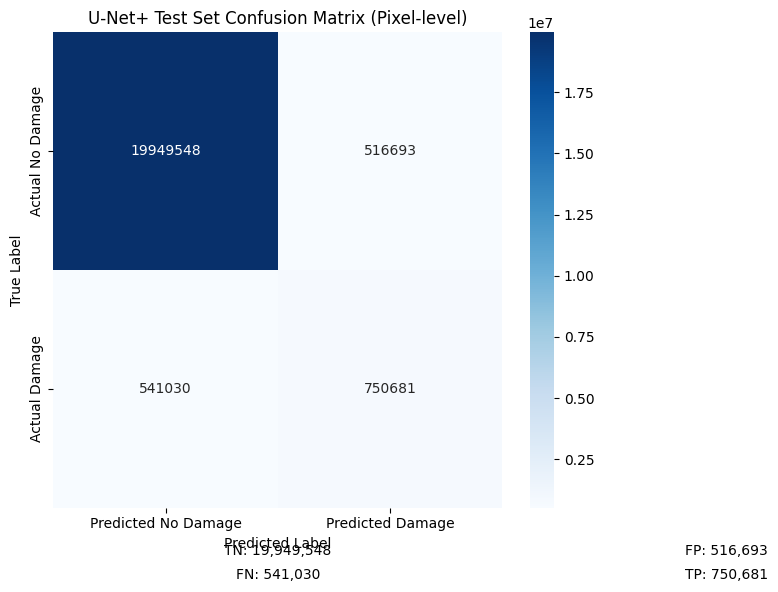

U-Net+ training and evaluation completed!


In [8]:
print("Loading best U-Net+ model for test evaluation...")
model.load_state_dict(torch.load('best_unetplus_earthquake.pth', map_location=device))
model.to(device)
print("\nEvaluating U-Net+ on test set...")
test_metrics = validate(model, test_loader)
print("\n" + "="*50)
print("U-NET+ TEST EVALUATION METRICS")
print("Configuration: (lr=2e-4, dropout=0.15, threshold=0.5)")
print("="*50)
print(f"Test set processed with batch_size=1")
print(f"Loss:            {test_metrics['loss']:.6f}")
print(f"IoU:             {test_metrics['iou']:.4f}")
print(f"mIoU:            {test_metrics['miou']:.4f}")
print(f"Dice Coefficient: {test_metrics['dice']:.4f}")
print(f"Accuracy:        {test_metrics['acc']:.4f}")
print(f"Precision:       {test_metrics['precision']:.4f}")
print(f"Recall:          {test_metrics['recall']:.4f}")
print(f"F1-Score:        {test_metrics['f1']:.4f}")
print("Confusion matrix (pixel-level):")
print(test_metrics["confusion"])
print("="*50)
plt.figure(figsize=(8, 6))
cm = test_metrics["confusion"]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No Damage', 'Predicted Damage'], yticklabels=['Actual No Damage', 'Actual Damage'])
plt.title('U-Net+ Test Set Confusion Matrix (Pixel-level)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.text(0.5, -0.1, f'TN: {cm[0,0]:,}', ha='center', transform=plt.gca().transAxes)
plt.text(1.5, -0.1, f'FP: {cm[0,1]:,}', ha='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.15, f'FN: {cm[1,0]:,}', ha='center', transform=plt.gca().transAxes)
plt.text(1.5, -0.15, f'TP: {cm[1,1]:,}', ha='center', transform=plt.gca().transAxes)
plt.tight_layout()
plt.savefig('unetplus_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("U-Net+ training and evaluation completed!")